In [1]:
import pandas as pd
import numpy as np
from src.process import Process, RFMData
from src.models import BgNbd, NewBgNbd
from src.clv import CLV, Metric

In [2]:
# p = Process('data/raw_data/', 'data.csv')
# cig_data = p.get_kind_data(0)
# wine_data = p.get_kind_data(1)
# other_data = p.get_kind_data(2)
# cig_data.to_csv('data/cig_data.csv', index=False, encoding='utf_8_sig')
# wine_data.to_csv('data/wine_data.csv', index=False, encoding='utf_8_sig')
# other_data.to_csv('data/other_data.csv', index=False, encoding='utf_8_sig')

cig_data = pd.read_csv('data/cig_data.csv')
wine_data = pd.read_csv('data/wine_data.csv')
other_data = pd.read_csv('data/other_data.csv')

In [3]:
# tmp = p.df[['会员姓名', '电话', '会员生日', '性别', '年龄', '消费时间', '商品名称', '单位', '商品数量', '实收金额', 'id']]
# tmp = wine_data[['会员姓名', '电话', '会员生日', '性别', '年龄', '消费时间', '商品名称', '单位', '商品数量', '实收金额', 'id']]
use_cols = ['会员姓名', '电话', '会员生日', '性别', '年龄', '消费时间', '商品名称', '单位', '商品数量', '实收金额', 'id']

In [4]:
clv = CLV(cig_data[use_cols], wine_data[use_cols], other_data[use_cols])

## 原模型

In [5]:
gather_res = clv.gather_clv()
rfm = gather_res['rfm']
test_data = rfm.test_data
data = rfm.get_features(rfm.train_data)
true_df = test_data.groupby('id')['实收金额'].sum().reset_index()
true_df.columns = ['id', 'true']
pred_df = gather_res['gg_model'].customer_lifetime_value(gather_res['bg_model'], 
                                               data['frequency'], 
                                               data['recency'], 
                                               data['T'],
                                               data['money'],
                                               time=30)
pred_df = pd.DataFrame({'id': data['id'], 'pred': pred_df})
pred_df = pred_df.merge(true_df, on='id')

In [6]:
metric = Metric(pred_df['true'], pred_df['pred'], name='CLV')
metric.summary()

,mae,mdae,rmse,pearson,spearmanr,loss
CLV,17802.939836,10578.799053,30570.602504,0.675524,0.522031,6523.77%


## 改进CLV - RMF/P

In [7]:
partial_res = clv.partial_clv()
test_data = pd.concat([partial_res['rfm_cig'].test_data, partial_res['rfm_wine'].test_data, partial_res['rfm_other'].test_data])
true_df = test_data.groupby('id')['实收金额'].sum().reset_index()
true_df.columns = ['id', 'true']
pred_df = pd.DataFrame()
for name in ['cig', 'wine', 'other']:
    data = partial_res[f'rfm_{name}'].get_features(partial_res[f'rfm_{name}'].train_data)
    pred = partial_res[f'gg_{name}'].customer_lifetime_value(gather_res['bg_model'], 
                                               data['frequency'], 
                                               data['recency'], 
                                               data['T'],
                                               data['money'],
                                               time=30)
    pred_df = pd.concat([pred_df, pd.DataFrame({'id': data['id'], 'pred': pred})])

pred_df = pred_df.groupby('id')['pred'].sum().reset_index()
pred_df.columns = ['id', 'pred']
pred_df = pred_df.merge(true_df, on='id')

In [8]:
metric = Metric(pred_df['true'], pred_df['pred'], name='改进CLV - RMF/P')
metric.summary()

,mae,mdae,rmse,pearson,spearmanr,loss
改进CLV - RMF/P,19097.891019,10522.710152,34342.627078,0.676831,0.509392,6290.37%


## 改进CLV- 改进BG/NBD

In [9]:
partial_res = clv.partial_clv(type=1)
test_data = pd.concat([partial_res['rfm_cig'].test_data, partial_res['rfm_wine'].test_data, partial_res['rfm_other'].test_data])
true_df = test_data.groupby('id')['实收金额'].sum().reset_index()
true_df.columns = ['id', 'true']
pred_df = pd.DataFrame()
for name in ['cig', 'wine', 'other']:
    data = partial_res[f'rfm_{name}'].get_features(partial_res[f'rfm_{name}'].train_data)
    pred = partial_res[f'gg_{name}'].customer_lifetime_value(gather_res['bg_model'], 
                                               data['frequency'], 
                                               data['recency'], 
                                               data['T'],
                                               data['money'],
                                               time=30)
    pred_df = pd.concat([pred_df, pd.DataFrame({'id': data['id'], 'pred': pred})])

pred_df = pred_df.groupby('id')['pred'].mean().reset_index()
pred_df.columns = ['id', 'pred']
pred_df = pred_df.merge(true_df, on='id')

In [10]:
metric = Metric(pred_df['true'], pred_df['pred'], name='改进CLV- 改进BG/NBD')
metric.summary()

,mae,mdae,rmse,pearson,spearmanr,loss
改进CLV- 改进BG/NBD,10673.405598,5982.491531,20016.533847,0.587096,0.485748,3676.57%


## 画图

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
from lifetimes.utils import summary_data_from_transaction_data
plt.rc('font',**{'family':'sans-serif','sans-serif':['simsun']})
plt.rcParams['figure.dpi']=150
plt.style.use('bmh')

# clv_plot = summary_data_from_transaction_data(test_data, customer_id_col='id', datetime_col='消费时间', monetary_value_col='实收金额').reset_index()
# clv_plot = test_data.groupby('id')['消费时间'].count().reset_index()
# clv_plot.columns = ['id', 'count']
clv_plot = gather_res['rfm'].get_features(test_data)
clv_plot = clv_plot.merge(pred_df, on='id')

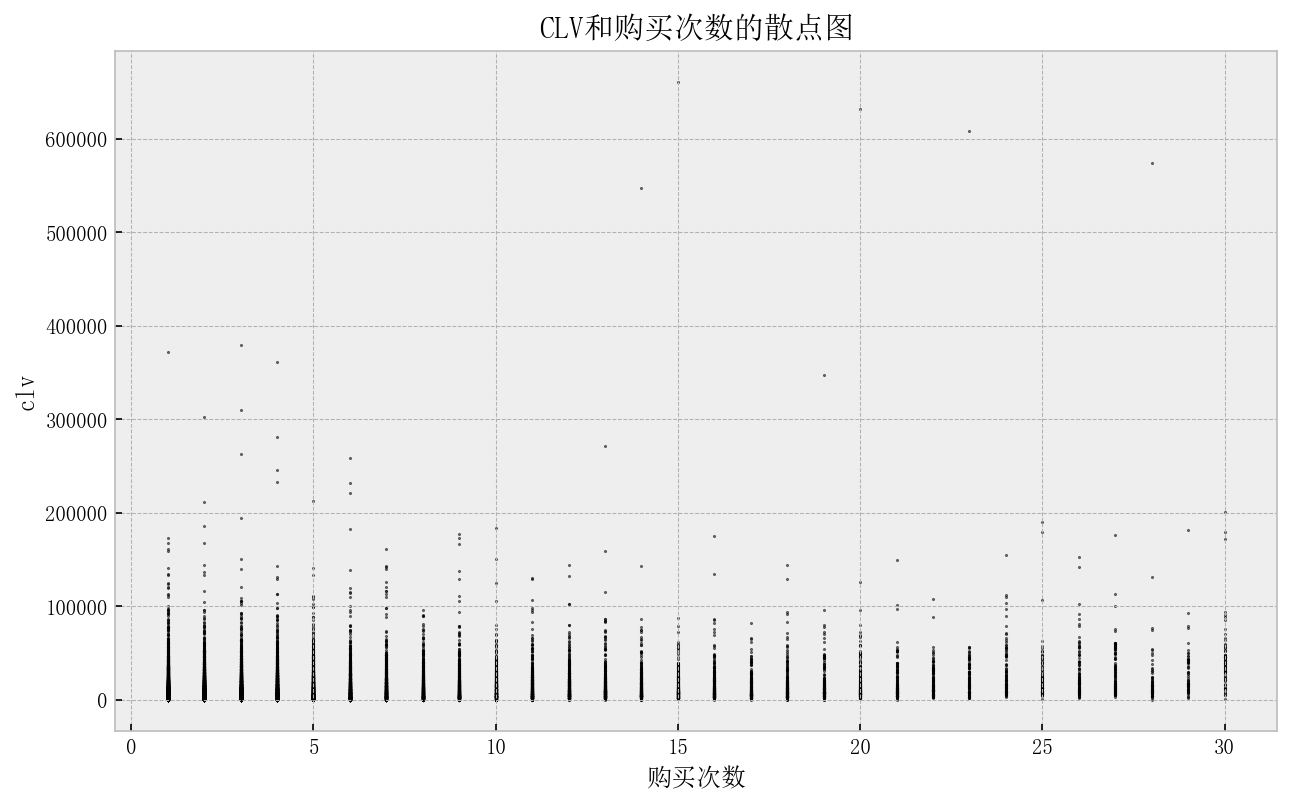

In [12]:
plt.figure(figsize=(10, 6))
plt.scatter(clv_plot['frequency'], clv_plot['pred'],s=1,alpha=0.5,color='black')
plt.xlabel('购买次数')
plt.ylabel('clv')
plt.title('CLV和购买次数的散点图')
plt.show()

In [12]:
count_mean = clv_plot['frequency'].mean()
clv_mean = clv_plot['pred'].mean()

def get_label(x):
    if x['pred'] > clv_mean:
        if x['frequency'] > count_mean:
            return 'Ⅰ'
        else:
            return 'Ⅱ'
    else:
        if x['frequency'] > count_mean:
            return 'Ⅲ'
        else:
            return 'Ⅳ'
clv_plot['label'] = clv_plot.apply(get_label, axis=1)

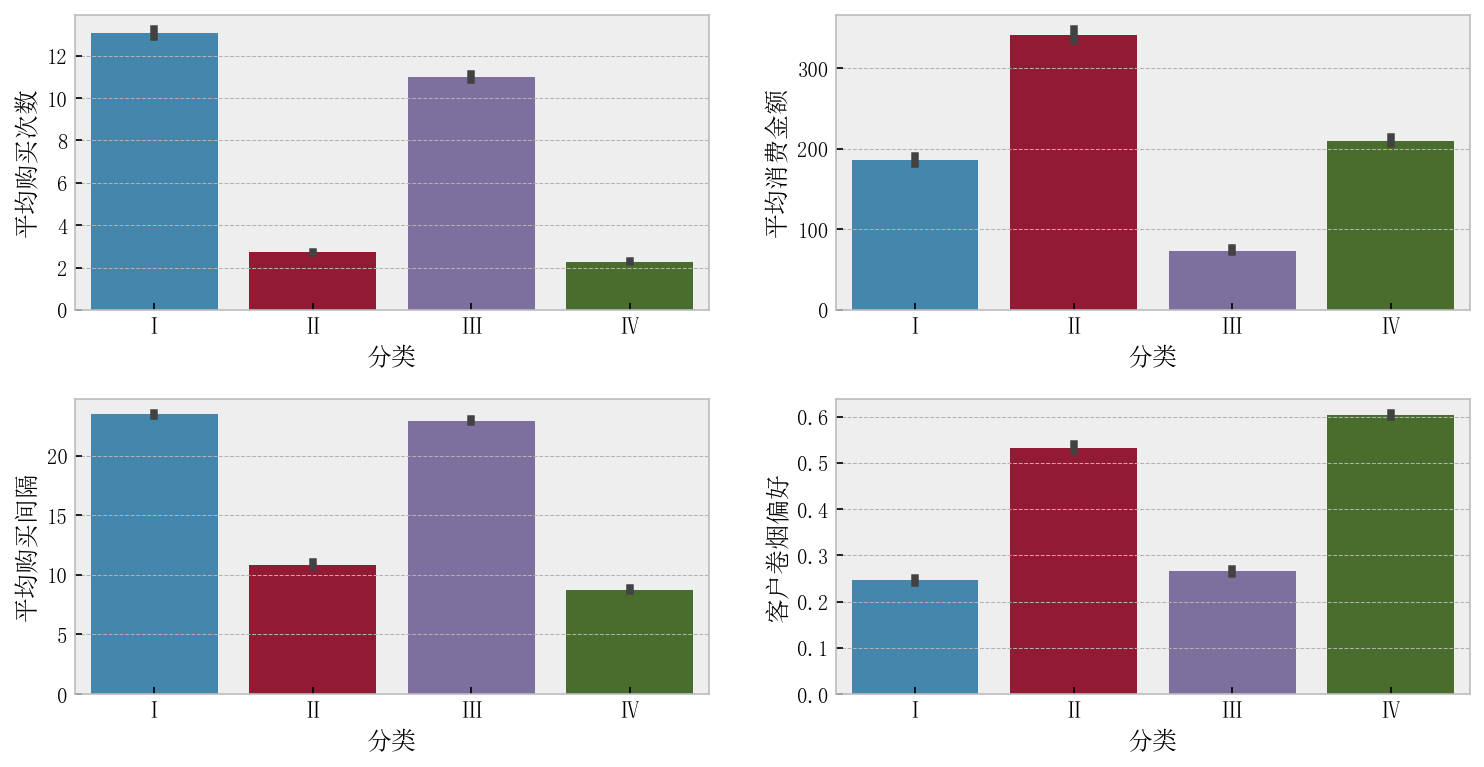

In [14]:
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(2, 2, 1)
sns.barplot(data=clv_plot, x='label', y='frequency', order=['Ⅰ', 'Ⅱ', 'Ⅲ', 'Ⅳ'], ax=ax)
ax.set_xlabel('分类')
ax.set_ylabel('平均购买次数')

ax = fig.add_subplot(2, 2, 2)
sns.barplot(data=clv_plot, x='label', y='money', order=['Ⅰ', 'Ⅱ', 'Ⅲ', 'Ⅳ'], ax=ax)
ax.set_xlabel('分类')
ax.set_ylabel('平均消费金额')

ax = fig.add_subplot(2, 2, 3)
sns.barplot(data=clv_plot, x='label', y='recency', order=['Ⅰ', 'Ⅱ', 'Ⅲ', 'Ⅳ'], ax=ax)
ax.set_xlabel('分类')
ax.set_ylabel('平均购买间隔')

ax = fig.add_subplot(2, 2, 4)
sns.barplot(data=clv_plot, x='label', y='preference', order=['Ⅰ', 'Ⅱ', 'Ⅲ', 'Ⅳ'], ax=ax)
ax.set_xlabel('分类')
ax.set_ylabel('客户卷烟偏好')
plt.subplots_adjust(hspace=0.3)

In [26]:
result = clv_plot.groupby('label').agg({'id': 'count', 'pred': 'mean'}).reset_index()
result.columns = ['分类', '人数', '贡献的价值']
result['人数占比'] = round(result['人数'] / result['人数'].sum() * 100, 2)
result['人数占比'] = result['人数占比'].astype(str) + '%'
result['贡献的价值占比'] = round(result['贡献的价值'] / result['贡献的价值'].sum() * 100, 2)
result['贡献的价值占比'] = result['贡献的价值占比'].astype(str) + '%'

In [27]:
result

,分类,人数,贡献的价值,人数占比,贡献的价值占比
0,Ⅰ,4291,29057.722549,13.49%,46.1%
1,Ⅱ,6047,24823.359840,19.02%,39.38%
2,Ⅲ,4872,5607.712250,15.32%,8.9%
3,Ⅳ,16591,3540.417864,52.17%,5.62%


## 改进CLV-改进BG/NBD（全）

In [17]:
partial_res = clv.partial_clv(type=2)
test_data = pd.concat([partial_res['rfm_cig'].test_data, partial_res['rfm_wine'].test_data, partial_res['rfm_other'].test_data])
true_df = test_data.groupby('id')['实收金额'].sum().reset_index()
true_df.columns = ['id', 'true']
pred_df = pd.DataFrame()
for name in ['cig', 'wine', 'other']:
    data = partial_res[f'rfm_{name}'].get_features(partial_res[f'rfm_{name}'].train_data)
    pred = gather_res['gg_model'].customer_lifetime_value(gather_res['bg_model'], 
                                               data['frequency'], 
                                               data['recency'], 
                                               data['T'],
                                               data['money'],
                                               time=30)
    pred_df = pd.concat([pred_df, pd.DataFrame({'id': data['id'], 'pred': pred})])

pred_df = pred_df.groupby('id')['pred'].mean().reset_index()
pred_df.columns = ['id', 'pred']
pred_df = pred_df.merge(true_df, on='id')

In [19]:
metric = Metric(pred_df['true'], pred_df['pred'], name='改进CLV- 改进BG/NBD（全）')
metric.summary()

,mae,mdae,rmse,pearson,spearmanr,loss
改进CLV- 改进BG/NBD（全）,10916.23772,6077.264322,20736.662785,0.584991,0.483627,3795.74%


In [36]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.rc('font',**{'family':'sans-serif','sans-serif':['simsun']})
plt.rcParams['figure.dpi']=150
plt.style.use('bmh')

clv_plot = gather_res['rfm'].get_features(test_data)
clv_plot = clv_plot.merge(pred_df, on='id')

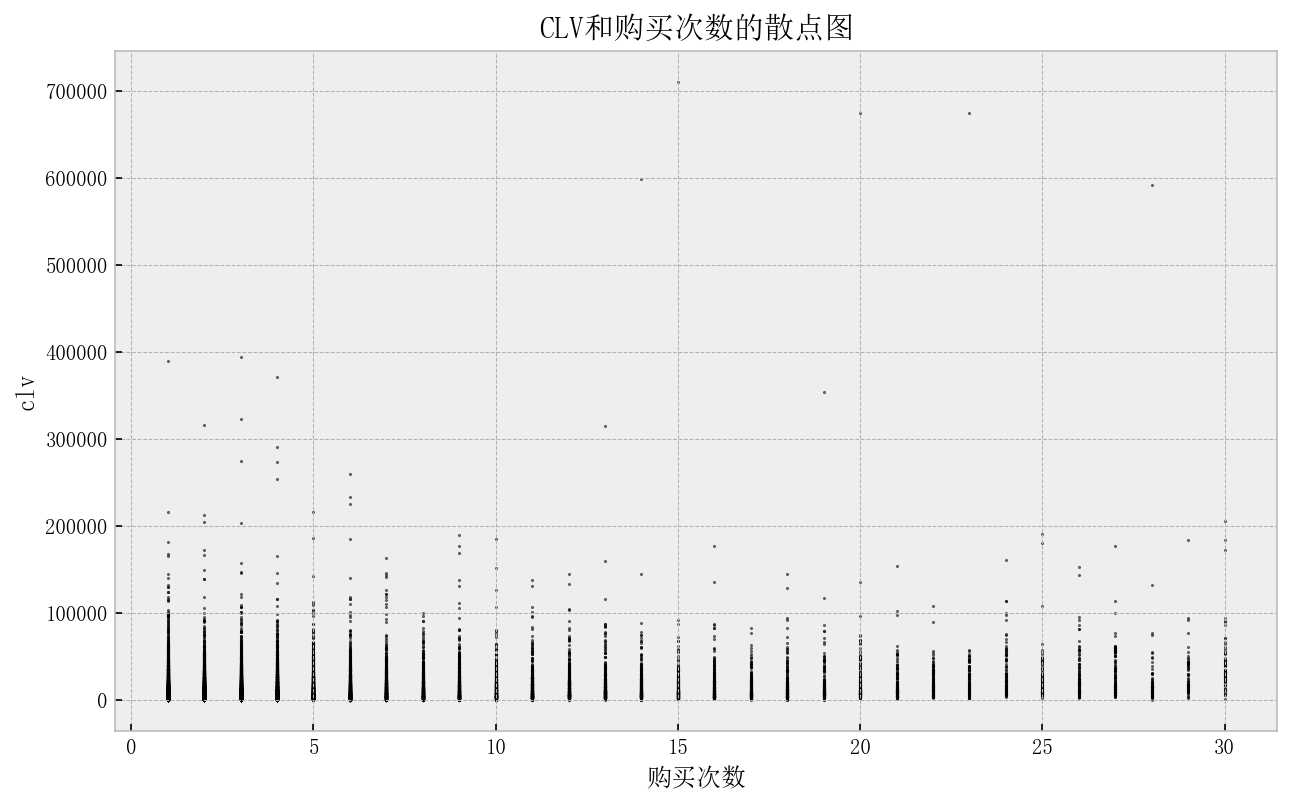

In [37]:
plt.figure(figsize=(10, 6))
plt.scatter(clv_plot['frequency'], clv_plot['pred'],s=1,alpha=0.5,color='black')
plt.xlabel('购买次数')
plt.ylabel('clv')
plt.title('CLV和购买次数的散点图')
plt.show()

In [38]:
count_mean = clv_plot['frequency'].mean()
clv_mean = clv_plot['pred'].mean()

def get_label(x):
    if x['pred'] > clv_mean:
        if x['frequency'] > count_mean:
            return 'Ⅰ'
        else:
            return 'Ⅱ'
    else:
        if x['frequency'] > count_mean:
            return 'Ⅲ'
        else:
            return 'Ⅳ'
clv_plot['label'] = clv_plot.apply(get_label, axis=1)

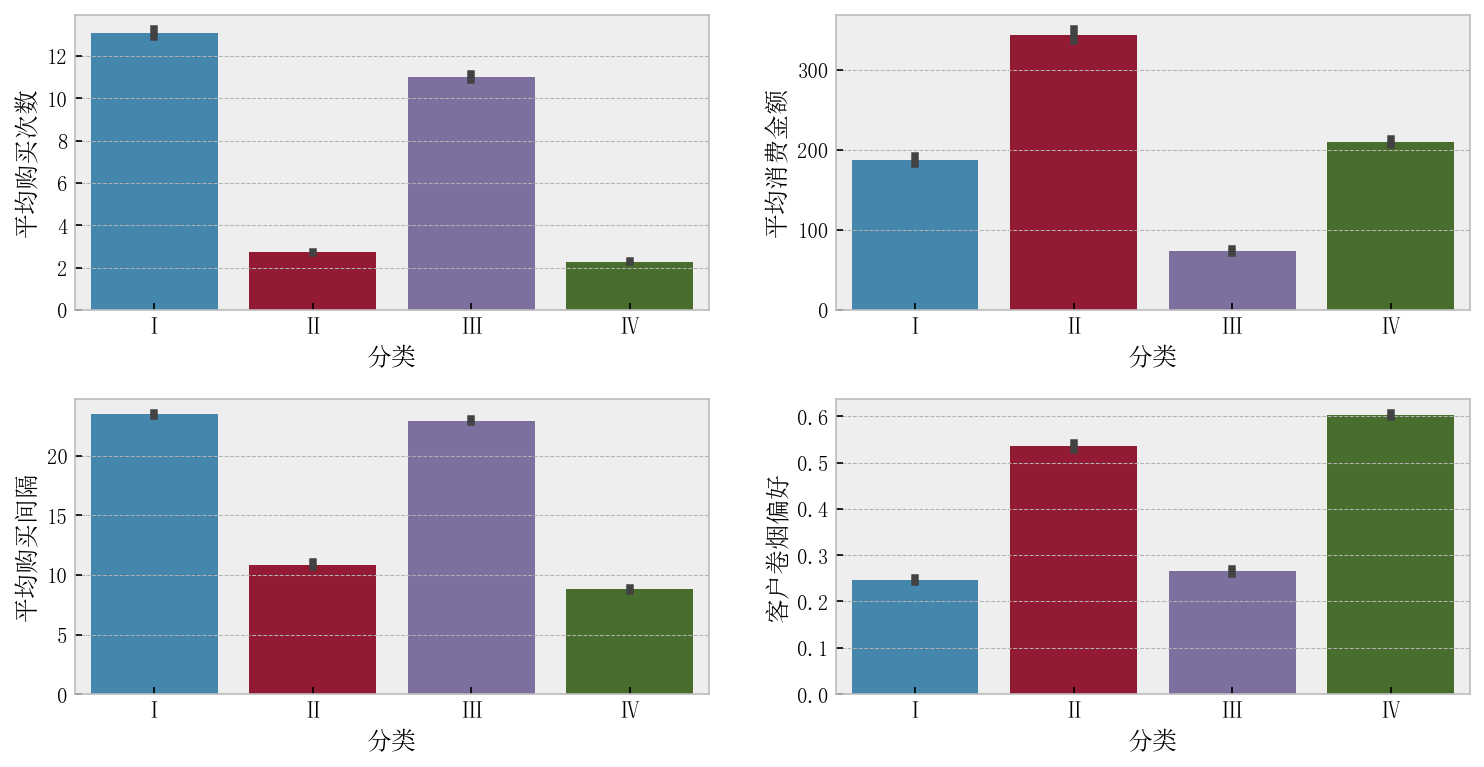

In [39]:
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(2, 2, 1)
sns.barplot(data=clv_plot, x='label', y='frequency', order=['Ⅰ', 'Ⅱ', 'Ⅲ', 'Ⅳ'], ax=ax)
ax.set_xlabel('分类')
ax.set_ylabel('平均购买次数')

ax = fig.add_subplot(2, 2, 2)
sns.barplot(data=clv_plot, x='label', y='money', order=['Ⅰ', 'Ⅱ', 'Ⅲ', 'Ⅳ'], ax=ax)
ax.set_xlabel('分类')
ax.set_ylabel('平均消费金额')

ax = fig.add_subplot(2, 2, 3)
sns.barplot(data=clv_plot, x='label', y='recency', order=['Ⅰ', 'Ⅱ', 'Ⅲ', 'Ⅳ'], ax=ax)
ax.set_xlabel('分类')
ax.set_ylabel('平均购买间隔')

ax = fig.add_subplot(2, 2, 4)
sns.barplot(data=clv_plot, x='label', y='preference', order=['Ⅰ', 'Ⅱ', 'Ⅲ', 'Ⅳ'], ax=ax)
ax.set_xlabel('分类')
ax.set_ylabel('客户卷烟偏好')
plt.subplots_adjust(hspace=0.3)

In [40]:
result = clv_plot.groupby('label').agg({'id': 'count', 'pred': 'mean'}).reset_index()
result.columns = ['分类', '人数', '贡献的价值']
result['人数占比'] = round(result['人数'] / result['人数'].sum() * 100, 2)
result['人数占比'] = result['人数占比'].astype(str) + '%'
result['贡献的价值占比'] = round(result['贡献的价值'] / result['贡献的价值'].sum() * 100, 2)
result['贡献的价值占比'] = result['贡献的价值占比'].astype(str) + '%'
result

,分类,人数,贡献的价值,人数占比,贡献的价值占比
0,Ⅰ,4248,29504.451555,13.36%,45.62%
1,Ⅱ,5982,25736.582634,18.81%,39.79%
2,Ⅲ,4915,5776.636685,15.46%,8.93%
3,Ⅳ,16656,3658.429180,52.38%,5.66%
